In [30]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *

utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-09-03 10:28:17.790381: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 10:28:19.165188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756916899.892261   48932 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756916900.067998   48932 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 10:28:21.369108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [31]:
client

<Client: 'tcp://128.117.208.184:45199' processes=20 threads=20, memory=465.60 GiB>

In [10]:
def fix_time(ds):
    yr0=str(ds['time.year'][0].values)
    ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS',calendar='noleap')
    return ds

In [ ]:
def preprocess(ds):
    dvs=['TOTSOMC','TOTECOSYSC']
    return ds[dvs]

In [12]:
def get_files(exp,case,keys=[],id='oaat'):
    s='/glade/campaign/cgd/tss/projects/PPE/'+exp+'/spin/'
        
    if not keys:
        if case=='HIST':
            c='BNF_v2.n01_ctsm5.3.012_transient_'+id+'*'
        else:
            c='BNF_v2.n01_ctsm5.3.012_transient_'+case+'_'+id+'*'
    keys=np.unique([d.split('_')[-1].split('.')[0] for d in sorted(glob.glob(s+c))])
    files=[]
    nfiles=0
    goodkeys=[]
    for k in keys:
        m='*.h0.*'
        if case=='HIST':
            c='BNF_v2.n01_ctsm5.3.012_transient_'+k
        else:
            c='BNF_v2.n01_ctsm5.3.012_transient_'+case+'_'+k
        d=s+c
        f=sorted(glob.glob(d+m))
        if not nfiles:
            nfiles=len(f)
        if len(f)==nfiles:
            files.append(f)
            goodkeys.append(k)
        else:
            print(case,k,len(f),'files')
    return files,goodkeys
        
        

In [13]:
def get_case(exp,case,inits,monthly):
    files,keys=get_files(exp,case)

    
    ds=xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                     preprocess=preprocess,decode_times=False)
    ds['ens']=keys

    if monthly[case]:
        ds['time']=xr.cftime_range(str(inits[case]),periods=len(ds.time),freq='MS',calendar='noleap')
        ds=xr.Dataset({v:amean(ds[v]) for v in ds.data_vars})
    else:
        ds=ds.isel(time=range(1,len(ds.time)))
        ds['year']=xr.DataArray(range(inits[case],inits[case]+len(ds.time)),dims='time')
        ds=ds.swap_dims({'time':'year'})
        
    return ds

In [14]:
la=xr.open_dataset(os.path.join(utils_path, "sparsegrid_landarea.nc")).landarea
inits={'AD':1710,'SASU':1730,'postSASU':1810,'HIST':1850}
monthly={'AD':False,'SASU':False,'postSASU':True,'HIST':True}

In [17]:
#cases=['AD','SASU','postSASU']
cases=['postSASU']
dsets={c:get_case('ctsm6_oaat',c,inits,monthly) for c in cases}

Exception ignored in: <function CachingFileManager.__del__ at 0x15244c594e50>
Traceback (most recent call last):
  File "/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 236, in __del__
    def __del__(self) -> None:
KeyboardInterrupt: 
Exception ignored in: <function CachingFileManager.__del__ at 0x15244c594e50>
Traceback (most recent call last):
  File "/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 236, in __del__
    def __del__(self) -> None:
KeyboardInterrupt: 
Exception ignored in: <function CachingFileManager.__del__ at 0x15244c594e50>
Traceback (most recent call last):
  File "/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 236, in __del__
    def __del__(self) -> None:
KeyboardInterrupt: 
Exception ignored in: <function CachingFileManager.__del__ at 0x15244c594e50>
Traceback (most recent call last):
  File "/gl

In [15]:
files,keys=get_files('ctsm6_oaat','postSASU',id='oaat')

In [ ]:
%%time
ds=xr.open_mfdataset(files[:118],combine='nested',concat_dim=['ens','time'],
                     preprocess=preprocess) # Removed parallel=True

In [ ]:
ds['ens']=keys[:118]
ds['time']=xr.cftime_range(str(inits['postSASU']),periods=len(ds.time),freq='MS',calendar='noleap')
ds=xr.Dataset({v:amean(ds[v]) for v in ds.data_vars})

### check postSASU drift

Text(0.5, 1.0, '|$\\Delta$TOTECOSYSC|<1g/m2/yr')

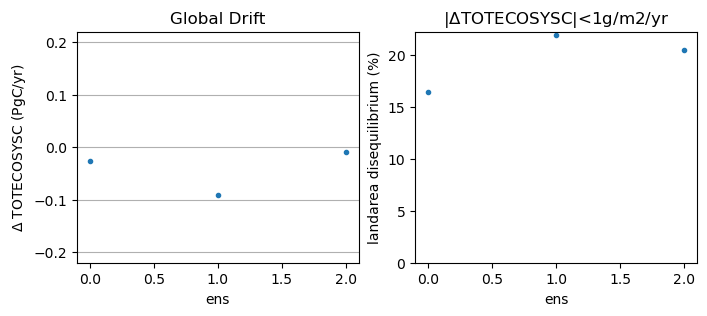

In [29]:
grams=1
#x=dsets['postSASU'].TOTECOSYSC
x = ds.TOTECOSYSC
ees=[int(ee[4:]) for ee in x.ens.values]
dx=(x-x.shift(year=20))

plt.figure(figsize=[8,3])

plt.subplot(121)
drift=1e-9*(la*dx.isel(year=range(20,40)).mean(dim='year')).sum(dim='gridcell')/20
plt.plot(ees[:119],drift[:119],'.')
plt.ylim([-0.22,0.22])
plt.grid(axis='y')
plt.xlabel('ens')
plt.ylabel('$\Delta$ TOTECOSYSC (PgC/yr)')
plt.title('Global Drift')

plt.subplot(122)
diseq=100*(la*(abs(dx.isel(year=range(20,40)).mean(dim='year'))>20*grams)).sum(dim='gridcell')/la.sum()
plt.plot(ees[:119],diseq[:119],'.')
plt.xlabel('ens')
plt.ylabel('landarea disequilibrium (%)')
plt.ylim(bottom=0)
plt.title('|$\Delta$TOTECOSYSC|<'+str(grams)+'g/m2/yr')
#plt.savefig('figs/spinup_stability_ctsm5.3.012.BNF.png',dpi=300,bbox_inches='tight');

### Check for jumps between spinup segments

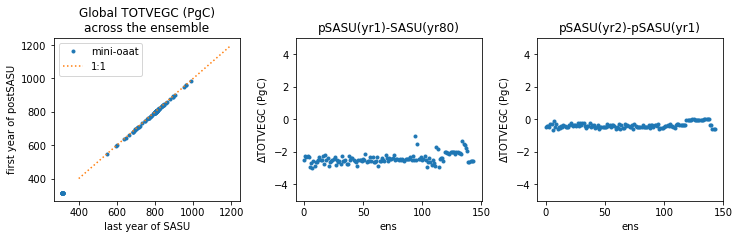

In [24]:
plt.figure(figsize=[12,3])
plt.subplot(131)
x=1e-9*(la*dsets['SASU'].TOTVEGC.isel(year=-1)).sum(dim='gridcell')
y=1e-9*(la*dsets['postSASU'].TOTVEGC.isel(year=0)).sum(dim='gridcell')
ees=[int(ee[4:]) for ee in y.ens.values]
plt.plot(x.sel(ens=y.ens),y,'.',label='mini-oaat')
yy=[400,1200]
plt.plot(yy,yy,':',label='1:1')
plt.xlabel('last year of SASU')
plt.ylabel('first year of postSASU')
plt.title('Global TOTVEGC (PgC)\nacross the ensemble')
plt.legend()
plt.subplot(132)
plt.plot(ees,y-x,'.')
plt.ylabel('$\Delta$TOTVEGC (PgC)')
plt.xlabel('ens')
plt.title('pSASU(yr1)-SASU(yr80)');
plt.ylim([-5,5])

plt.subplot(133)
y2=1e-9*(la*dsets['postSASU'].TOTVEGC.isel(year=1)).sum(dim='gridcell')
plt.plot(ees,y2-y,'.')
plt.ylabel('$\Delta$TOTVEGC (PgC)')
plt.xlabel('ens')
plt.title('pSASU(yr2)-pSASU(yr1)');
plt.ylim([-5,5]);
plt.subplots_adjust(wspace=0.3)

#plt.savefig('figs/TVC_jumps.png',dpi=300,bbox_inches='tight')

### Misc

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [20]:
la=xr.open_dataset(utils_path+'landarea_transient.nc')

In [21]:
tmp = xr.open_dataset('/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/hist/BNF_v2.n01_ctsm5.3.012_transient_oaat0115.clm2.h0.2020-02-01-00000.nc')

In [22]:
x=dsets['postSASU'].TOTECOSYSC
ees=[int(ee[4:]) for ee in x.ens.values]
dx=(x-x.shift(year=20))

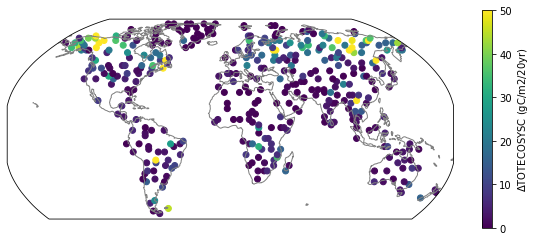

In [24]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson()) 
extent = [-180, 180,-60,90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(color='grey')

cx = np.abs((dx).isel(ens=165,year=range(20,40)).mean(dim='year'))
sc=ax.scatter(tmp.grid1d_lon,tmp.grid1d_lat,c=cx,vmin=0,vmax=50,
           transform=ccrs.PlateCarree())
plt.colorbar(sc,label='$\Delta$TOTECOSYSC (gC/m2/20yr)')
#plt.savefig('figs/'+k+'_gppjump_gridded.png',dpi=300,bbox_inches='tight');

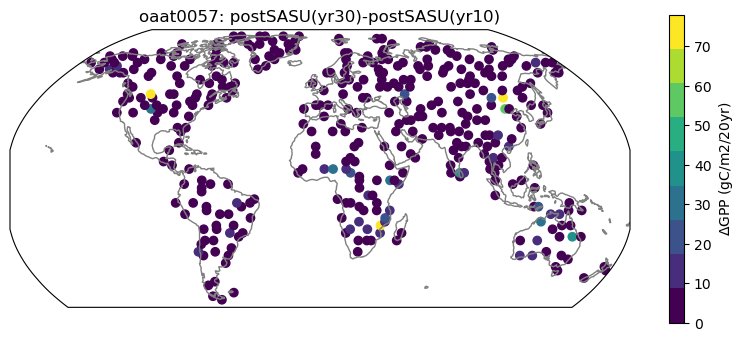

In [131]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson()) 
extent = [-180, 180,-60,90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(color='grey')

dx=abs(gpp.sel(year=1840)-gpp.sel(year=1820))
sc=ax.scatter(tmp.grid1d_lon,tmp.grid1d_lat,c=dx,
           transform=ccrs.PlateCarree(),cmap=cmap)
plt.colorbar(sc,label='$\Delta$GPP (gC/m2/20yr)')
plt.title(k+': postSASU(yr30)-postSASU(yr10)');
plt.savefig('figs/oaat0057_gpp_nojump_gridded.png',dpi=300,bbox_inches='tight');

### pft-level output
 - from a double spinup

In [7]:
d='/glade/derecho/scratch/linnia/ctsm5.3.0_transient_postSASU_test0010/run/'
files=sorted(glob.glob(d+'*.clm2.h1.*'))
ds=xr.open_mfdataset(files,combine='by_coords')
ds['time']=xr.cftime_range('2000',periods=len(ds.time),freq='MS',calendar='noleap')

In [ ]:
d='/glade/derecho/scratch/linnia/ctsm5.3.0_transient_SASU_test0010/run/'
files=sorted(glob.glob(d+'*.clm2.h1.*'))
ds0=xr.open_mfdataset(files,combine='by_coords')
ds0['time']=xr.cftime_range('2000',periods=len(ds0.time),freq='MS',calendar='noleap')

In [47]:
cfs={'TLAI':1,'TOTVEGC':1,'GPP':24*60*60*365}

In [48]:
xs={'SASU':{},'pSASU':{}}
for dset,c in zip([ds0,ds],xs):
    for v in ['TLAI','TOTVEGC','GPP']:
        xs[c][v]=cfs[v]*amean(dset[v])
    
        

In [54]:
ds.pfts1d_wtgcell.isel(time=0)

<xarray.DataArray 'pfts1d_wtgcell' (pft: 3978)>
dask.array<getitem, shape=(3978,), dtype=float64, chunksize=(3978,), chunktype=numpy.ndarray>
Coordinates:
    time     object 2000-01-01 00:00:00
Dimensions without coordinates: pft
Attributes:
    long_name:  pft weight relative to corresponding gridcell

In [75]:
lat=ds.pfts1d_lat.isel(time=0)
aa=ds.pfts1d_wtgcell.isel(time=0)*np.cos(np.deg2rad(lat))

In [84]:
dx=xs['pSASU'][v].isel(year=0)-xs['SASU'][v].isel(year=-1)
fromdead=(aa*dx).isel(pft=ixdead).sum()/(aa*dx).sum()
fromdead.values

array(1.03787101)

In [85]:
ixp=dx.argmax()

In [102]:
ds.pfts1d_itype_veg.isel(time=0,pft=ixp).values

array(4.)

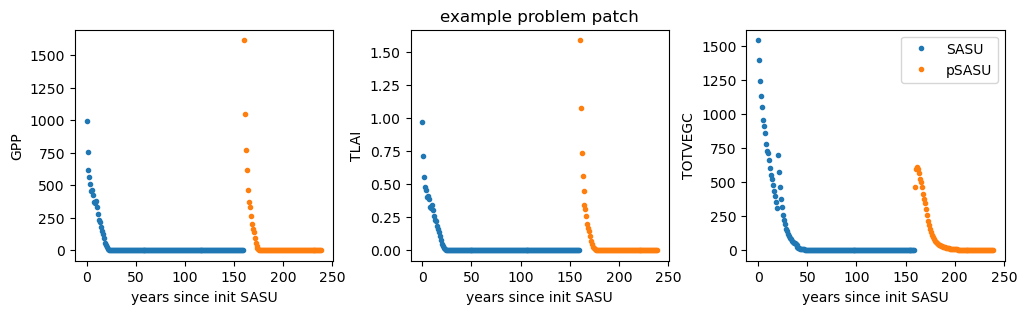

In [105]:
plt.figure(figsize=[12,3])
for i,v in enumerate(['GPP','TLAI','TOTVEGC']):
    plt.subplot(131+i)
    plt.plot(range(160),xs['SASU'][v].isel(pft=ixp),'.',label='SASU')
    plt.plot(range(160,240),xs['pSASU'][v].isel(pft=ixp),'.',label='pSASU')
    plt.xlabel('years since init SASU')
    plt.ylabel(v)
    if i==1:
        plt.title('example problem patch')
    if i==2:
        plt.legend()
    plt.savefig('figs/patch500_ts.png',dpi=300,bbox_inches='tight');
plt.subplots_adjust(wspace=0.3)

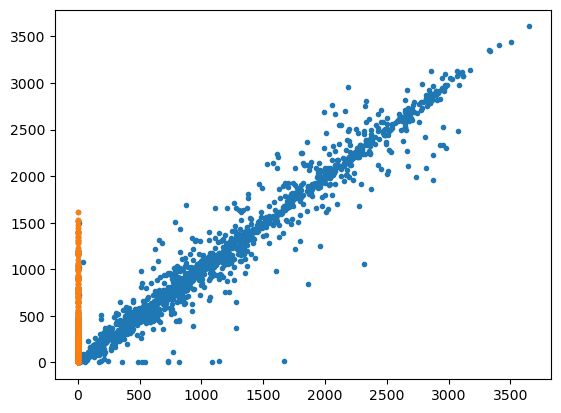

In [64]:
v='GPP'
ixdead=(xs['SASU'][v].isel(year=-1)==0).compute()
plt.plot(xs['SASU'][v].isel(year=-1),
         xs['pSASU'][v].isel(year=0),'.')

plt.plot(xs['SASU'][v].isel(pft=ixdead,year=-1),
         xs['pSASU'][v].isel(pft=ixdead,year=0),'.')

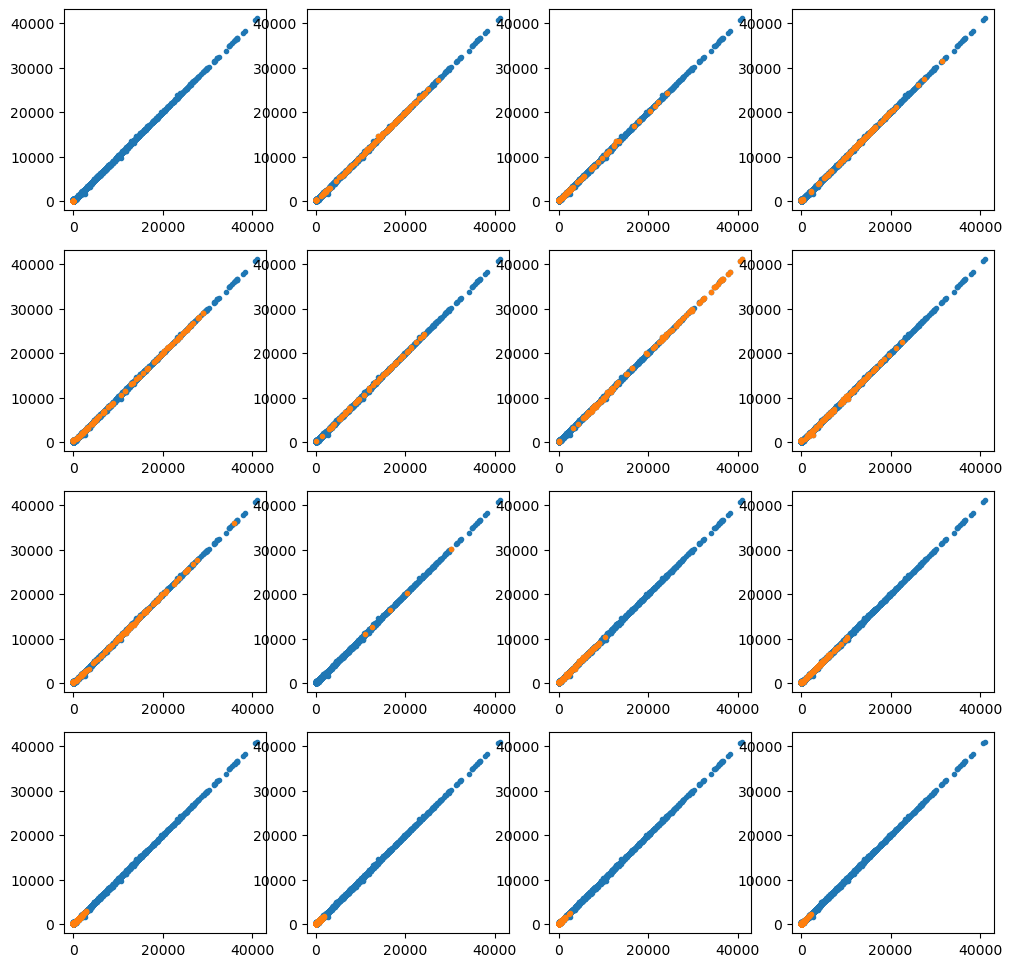

In [56]:
v='TOTVEGC'
plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(xs['SASU'][v].isel(year=-1),
             xs['pSASU'][v].isel(year=0),'.')
    ix=(ds.pfts1d_itype_veg.isel(time=0)==i).compute()
    plt.plot(xs['SASU'][v].isel(pft=ix,year=-1),
             xs['pSASU'][v].isel(pft=ix,year=0),'.')


In [ ]:
client.close()
cluster.close()
